In [22]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

## Load a Quantum Device
-  Set name as `default.qubit`. This device is used to simulate qubit-based quantum circuits.
-  Set `Wires` as `2`. This corresponds with the number of qubits in the circuit.

In [23]:
dev = qml.device('default.qubit', wires = 2)

## Create the Quantum Circuit Function
### Apply an $R_Y(\theta)$ Gate and a Controlled $R_X(\theta)$ Gate
#### Apply an $R_Y(\theta)$ Gate
Create a superposition of the $\ket{0}$ and $\ket{1}$ states by applying an $R_Y(\theta)$ gate to one of the qubits.
- Note that $\theta$ denotes the angle of rotation about the $y$-axis of the Bloch sphere. 
- The $R_Y$ gate transforms a quantum state as follows:
    $$ \alpha\ket{0} + \beta\ket{1} \xrightarrow{R_Y} \bigg(\alpha\cos{\frac{\theta}{2}}+\beta\sin{\frac{\theta}{2}}\bigg)\ket{0} + \bigg(\beta\cos{\frac{\theta}{2}} - \alpha\sin{\frac{\theta}{2}}\bigg)\ket{1} $$
#### Apply a Controlled $R_X(\theta)$ Gate
The **controlled $R_X(\theta)$ gate** is a two-qubit gate that has a control qubit and a target qubit. An $R_X(\theta)$ gate is applied to the target qubit only if the control qubit is in a state of $\ket{1}$.
- Mathematically expressed as follows:
    $$ \alpha\ket{0} + \beta\ket{1} \xrightarrow{CR_X} \bigg(\alpha\cos{\frac{\theta}{2}} - i\beta\sin{\frac{\theta}{2}})\ket{0} + \bigg(  \beta\cos{\frac{\theta}{2}} - i\alpha\sin{\frac{\theta}{2}} \bigg)\ket{1}$$

In [24]:
def circuit(theta):
    qml.RY(theta[0], wires = 0)
    qml.CRX(theta[1], wires = [0, 1])
    return qml.probs(wires = [0, 1])

## Create a Quantum Node
Use this to 'bind' your quantum circuit to your quantum device. 
- Once created, a quantum node has the functionalities of the circuit function and can be used to evaluate the simulation results

In [25]:
node = qml.QNode(circuit, dev)

## Visualize the Circuit
Let's check to see how the final circuit looks so that we can make sure sure the implementation is truly complete.

For this task, let's visualize the quantum circuit using `theta1` $=\frac{\pi}{2}$ and `theta2` $=\frac{\pi}{4}$.

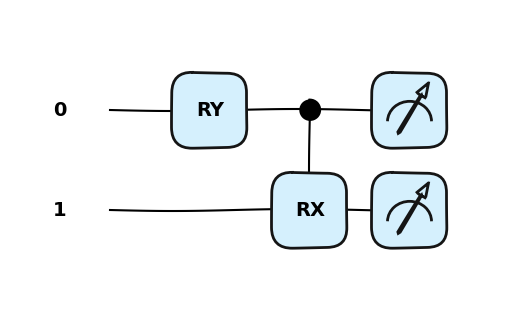

In [26]:
theta1 = np.pi/2
theta2 = np.pi/4

qml.drawer.use_style('pennylane_sketch')
fig = qml.draw_mpl(node)([theta1, theta2])

## Simulate the Circuit

In [27]:
print(node([theta1, theta2]))

[0.5       0.        0.4267767 0.0732233]


## Create the Cost Function
Create a function `cost()` that returns a cost for a given set of parameters. This function will have the following specifications:
- **Parameters**: The argument of the cost function is the array of circuit parameters
- **Return value**: The return value is the cost of teh circuit evaluated for the parameters
### Mean Squared Error
$$MSE = \sum_{i}{(y_i - y'_i)^2}$$
Here, 
- $y_i$ is the $i^{\text{th}}$ element of the cost array
- $y'_i$ is the $i^{\text{th}}$ element of the predicted array
  - For this task, the predicted array will be `[0.5, 0, 0, 0.5]`, which corresponds to the following  quantum state:
    $$\frac{\ket{00}+\ket{11}}{2}

In [28]:
predicted_array = [0.5, 0, 0, 0.5]
def cost(params):
    return np.sum(( node(params) -  predicted_array)**2)

## Initialize the Optimizer
In machine learning, an **optimizer** is a function that updates teh values of the parameters based on the cost value. The ultimate goal of the optimizer is to reduce the cost value by finding the parameters' optimal value.

Note 1: One of the key advantages of using PennyLane is that it provides automatic differentiation for gradient descent by default. 
- This is why we imported NumPy via PennyLane early on -- to leverage this functionality.

Note 2: PennyLane provides numerous optimizers in addition to providing the functionality to import optimizers from other libraries.
- This task will use the Adam optimizer to optimize the circuit.
  - The **Adam** optimizer is a type of gradient descent optimizer and is one of the best adaptive optimizers.
  - Apparently, this makes the Adam optimizer a good choice for our example. It is also good for the sake of simplicity.

Here, let's create an instance of the `AdamOptimizer` with a learning rate of `0.1`.

In [29]:
opt = qml.AdamOptimizer(stepsize = 0.1)

## Optimize the Circuit
Steps:
1. Set the initial value of the parameters to `0`.
   - 📝 Because t he parameters in gradient descent optimizers don't update when initialized to zero, you can use the machine's epsilon value as the initial value. This can be done using NumPy via `np.finfo(float).eps`.
2. Set the number of steps to `200`.
3. Define an empty array `cost_arr` which will store the cost of the circuit at each iteration.
4. Define an empty array `param_arr` that will store the parameters' values at each iteration of optimization.
5. Run `steps` iterations of optimization so that the following conditions are met:
   - The existing array of parameter values appends to the `param_arr` array.
   - The cost value at the existing value of parameters appends to the `cost_arr` array.
   - The parameters are updated by the optimizer.
   - The cost of the circuit for every fifth iteration of optimization is printed.
6. Print the results of the optimization

📝 The parameter values are in radians by default. To convert them to degrees, use the `degrees()` method of NumPy.

In [30]:
# set the initial value of the parameter
params = np.array([np.finfo(float).eps, np.finfo(float).eps])

# set the number of steps
steps = 200

# Arrays to store optimization results
param_arr = np.empty((steps, 2))
cost_arr = np.empty((steps, 1))

# Optimization
for i in range(steps):
    # update the circuit parameters
    param_arr[i] = params
    cost_arr[i] = cost(params)
    params = opt.step(cost, params)
    
    if (i + 1) % 5 == 0:
        print("Cost after step {:3d}: {: .7f}".format(i + 1, cost(params)))
        
# Print the results of the optimization
print("Optimized rotation angles: ", np.degrees(params))
print("Cost value at optimized parameters: ", cost(params))

Cost after step   5:  0.4910069
Cost after step  10:  0.4229506
Cost after step  15:  0.3483792
Cost after step  20:  0.2786532
Cost after step  25:  0.1409792
Cost after step  30:  0.0301649
Cost after step  35:  0.0098540
Cost after step  40:  0.0001905
Cost after step  45:  0.0035465
Cost after step  50:  0.0000351
Cost after step  55:  0.0010983
Cost after step  60:  0.0003015
Cost after step  65:  0.0002708
Cost after step  70:  0.0003632
Cost after step  75:  0.0001292
Cost after step  80:  0.0002065
Cost after step  85:  0.0001572
Cost after step  90:  0.0001046
Cost after step  95:  0.0001080
Cost after step 100:  0.0000873
Cost after step 105:  0.0000655
Cost after step 110:  0.0000574
Cost after step 115:  0.0000498
Cost after step 120:  0.0000409
Cost after step 125:  0.0000342
Cost after step 130:  0.0000296
Cost after step 135:  0.0000258
Cost after step 140:  0.0000224
Cost after step 145:  0.0000195
Cost after step 150:  0.0000171
Cost after step 155:  0.0000151
Cost aft

## Visualize the Optimization Process
To plot the results, follow the following tasks:
- Import the helper function `plot_opt_surface(costs, params, cost_func)` from the file `surface_plot.py`.
- Call the function `plot_opt_surface()`, and pass the cost and parameter arrays as arguments.

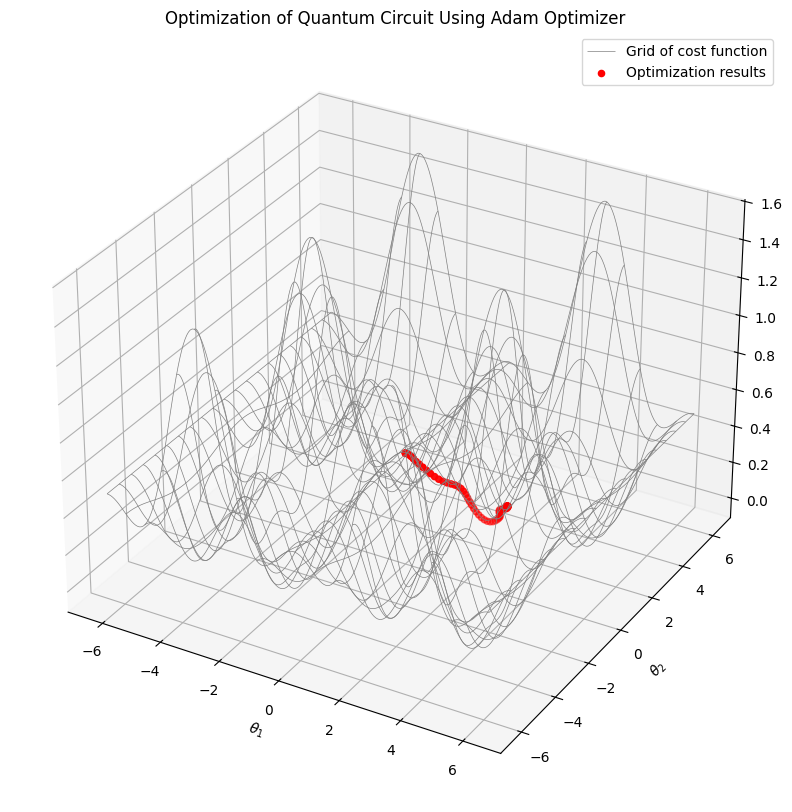

In [33]:
from surface_plot import *
plot_opt_surface(cost_arr, param_arr, cost)